# EM + Atlas 

In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
#from scipy.spatial.distance import dice

/home/okozyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Normalize array from 0 to 1
def normalize(target_array):
    target_array -= target_array.min()
    normalized_array = np.divide(target_array, target_array.max())
    return normalized_array

def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()
    
def show_slice_data(data, slice_no):
    plt.imshow(data[slice_no], cmap = "gray")
    plt.show()

# Read nii from path and normalize array from 0 to 1
def read_im(image_path):
    nii_img = nib.load(image_path)
    nii_data = nii_img.get_data()
    nii_data = normalize(nii_data)
    return nii_data, nii_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score

def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions  1) CSF (darkest) 3) GM (middle) 2) WM (light)
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    
    CSF_label = 1
    GM_label = 3
    WM_label = 2
    
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == CSF_label) * 1
    gt_CSF = (groundtruth_data == CSF_label) * 1
    seg_GM = (segmented_data == GM_label) * 1
    gt_GM = (groundtruth_data == GM_label) * 1
    seg_WM = (segmented_data == WM_label) * 1
    gt_WM = (groundtruth_data == WM_label) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

def apply_mask(target_data, gt_data):
    """
    Create mask using groundtruth image and apply it.
    
    Inputs: 
        gt_img: groundtuth mask
        target_img: raw data, apply mask to it
    
    Returns: 
        masked_img: target image with mask applied (background removed)
    """
    
    
    # Create mask: Select pixels higher than 0 in gt and set to 1
    gt_data[gt_data > 0] = 1
    
    # Apply mask
    target_data = np.multiply(target_data, gt_data)
    
    
    return target_data

def gaussian_mixture(features, mean, cov):
    """
    Return Gaussian mixture function for a class.
    
    Inputs:
        features (numpy.ndarray): n by d dimentional array of features of points from feature space, where d is 
                                  is the dimentionality of feature space, n - number of points in the data.
        mean (numpy.ndarray): d-dimentional mean value.
        con (numpy.ndarray): d by d dimentional covariance matrix.
    
    Returns:
        (numpy.ndarray): Gaussian mixture for every point in feature space.
    """
    return np.exp(-0.5*(features - mean) * (1/cov) * np.transpose(features - mean)) / (2 * pi * sqrt(cov))

def membership_weight(p0, p1, p2, a0, a1, a2):
    """
    Return membership weights for three classes.
    
    Inputs:
        p0 (numpy.ndarray): mixture component for the 0th class, which is a probability distribution.
        p1 (numpy.ndarray): mixture component for the 1st class, which is a probability distribution.
        p2 (numpy.ndarray): mixture component for the 2nd class, which is a probability distribution.
        a0 (float): the probability of the 0th class.
        a1 (float): the probability for the 1st class.
        a2 (float): the probability for the 2nd class.
        
    Returns:
        (numpy.ndarray): membership weights for each point from the feature space, 
    """
    denominator = (p0 * a0) + (p1 * a1) + (p2 * a2)
    w0 = (p0 * a0) / denominator
    w1 = (p1 * a1) / denominator
    w2 = (p2 * a2) / denominator
    
    return np.stack((w0, w1, w2), axis=1)

def seg_data_to_nii(original_im, y_pred, features_nonzero_row_indicies):
    """
        Inputs: original_im (nibabel): original image nii file
                y_pred (np array): labels for all non-zero points
                features_nonzero_row_indicies (np array): indicies of non-zero points,
                                                          same length as y_pred
        Returns: segment_nii (nibabel): segmented labels nii file        
        """
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred) + 1
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)
    return segment_nii

def integrate_atlas_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies, weights, csf_atlas, 
                           gm_atlas, wm_atlas):
    """
    Transforms segmenation result to nii file, puts correct labels in place.
    The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    
    Inputs: 
    original_im (nibabel): original image nii file
    y_pred (np array): labels for all non-zero points
    features_nonzero (np array): feature vector of only non-zero intensities
    features_nonzero_row_indicies (np array): indicies of non-zero points,
                                              same length as y_pred

    Returns:
    segment_nii (nibabel): segmented labels nii file        
    """
    
    # Create image with all 3 classes and random labels
    y_pred[np.argwhere(y_pred == 0)] = 3 # change labels from (0->2) to 1->3)
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    segment_im[features_nonzero_row_indicies] = y_pred
    segment_im = np.reshape(segment_im, original_im.shape)
    
    temp_class1_im = np.zeros_like(segment_im)
    temp_class2_im = np.zeros_like(segment_im)
    temp_class3_im = np.zeros_like(segment_im)
    
    #Assign class1 to 1
    temp_class1_im[segment_im == 1] = 1
    #Assign class2 to 2
    temp_class2_im[segment_im == 2] = 1
    #Assign class3 to 1
    temp_class3_im[segment_im == 3] = 1
    
    # Compute DICE between each class to determine which class it belongs to
    dice1 = [calc_dice(temp_class1_im, csf_atlas), calc_dice(temp_class2_im, csf_atlas), 
                                  calc_dice(temp_class3_im, csf_atlas)]
    dice2 = [calc_dice(temp_class1_im, wm_atlas), calc_dice(temp_class2_im, wm_atlas), 
                                  calc_dice(temp_class3_im, wm_atlas)]
    dice3 = [calc_dice(temp_class1_im, gm_atlas), calc_dice(temp_class2_im, gm_atlas), 
                                  calc_dice(temp_class3_im, gm_atlas)]
    csf_to_change = np.argmax(dice1) + 1
    wm_to_change = np.argmax(dice2) + 1
    gm_to_change = np.argmax(dice3) + 1
    
    
    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to its correct label
    y_pred_corrected_labels[y_pred == csf_to_change] = CSF_label
    #Assign GM to its correct label
    y_pred_corrected_labels[y_pred == gm_to_change] = GM_label
    #Assign WM to its correct label
    y_pred_corrected_labels[y_pred == wm_to_change] = WM_label

    # Multiply EM weights by Atlas
    
    # Get weights back into original shape
    original_im_flat = original_im.get_data().copy().flatten()
    weight_csf_im = np.zeros_like(original_im_flat)
    weight_gm_im = np.zeros_like(original_im_flat)
    weight_wm_im = np.zeros_like(original_im_flat)
    weight_csf_im[features_nonzero_row_indicies] = weights[:,csf_to_change-1]
    weight_gm_im[features_nonzero_row_indicies] = weights[:,gm_to_change-1]
    weight_wm_im[features_nonzero_row_indicies] = weights[:,wm_to_change-1]
    weight_csf_im = np.reshape(weight_csf_im, original_im.shape)
    weight_gm_im = np.reshape(weight_gm_im, original_im.shape)
    weight_wm_im = np.reshape(weight_wm_im, original_im.shape)
    
    # Multiply weights by each atlas
    csf_probs = weight_csf_im * csf_atlas
    gm_probs = weight_gm_im * gm_atlas
    wm_probs = weight_wm_im * wm_atlas
    
    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((gm_probs > csf_probs) * (gm_probs > wm_probs))
    WM = WM_label * np.nan_to_num((wm_probs > csf_probs) * (wm_probs > gm_probs))
    CSF = CSF_label * np.nan_to_num((csf_probs > wm_probs) * (csf_probs > gm_probs))
    seg_im = GM + WM + CSF
    
    segment_im = np.zeros_like(original_im_flat)
    segment_im = np.reshape(seg_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)

    return segment_nii

def seg_correct_labels_to_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies, csf_atlas, 
                           gm_atlas, wm_atlas):
    """
    Transforms segmenation result to nii file, puts correct labels in place.
    The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    
    Inputs: 
    original_im (nibabel): original image nii file
    y_pred (np array): labels for all non-zero points
    features_nonzero (np array): feature vector of only non-zero intensities
    features_nonzero_row_indicies (np array): indicies of non-zero points,
                                              same length as y_pred

    Returns:
    segment_nii (nibabel): segmented labels nii file        
    """
    
    # Create image with all 3 classes and random labels
    y_pred[np.argwhere(y_pred == 0)] = 3 # change labels from (0->2) to 1->3)
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    segment_im[features_nonzero_row_indicies] = y_pred
    segment_im = np.reshape(segment_im, original_im.shape)
    
    temp_class1_im = np.zeros_like(segment_im)
    temp_class2_im = np.zeros_like(segment_im)
    temp_class3_im = np.zeros_like(segment_im)
    
    #Assign class1 to 1
    temp_class1_im[segment_im == 1] = 1
    #Assign class2 to 2
    temp_class2_im[segment_im == 2] = 1
    #Assign class3 to 1
    temp_class3_im[segment_im == 3] = 1
    
    # Compute DICE between each class to determine which class it belongs to
    dice1 = [calc_dice(temp_class1_im, csf_atlas), calc_dice(temp_class2_im, csf_atlas), 
                                  calc_dice(temp_class3_im, csf_atlas)]
    dice2 = [calc_dice(temp_class1_im, wm_atlas), calc_dice(temp_class2_im, wm_atlas), 
                                  calc_dice(temp_class3_im, wm_atlas)]
    dice3 = [calc_dice(temp_class1_im, gm_atlas), calc_dice(temp_class2_im, gm_atlas), 
                                  calc_dice(temp_class3_im, gm_atlas)]
    csf_to_change = np.argmax(dice1) + 1
    wm_to_change = np.argmax(dice2) + 1
    gm_to_change = np.argmax(dice3) + 1
    
    
    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to its correct label
    y_pred_corrected_labels[y_pred == csf_to_change] = CSF_label
    #Assign GM to its correct label
    y_pred_corrected_labels[y_pred == gm_to_change] = GM_label
    #Assign WM to its correct label
    y_pred_corrected_labels[y_pred == wm_to_change] = WM_label

    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred_corrected_labels)
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)

    return segment_nii

# Data Preparation

In [4]:
# put either 'mni' or 'our' (made from provided test images)
use_atlas = 'mni'

MAX_STEPS = 30
min_change = 0.01
# select initial classes for each point, it can be either 'kmeans' or 'random'
class_init = 'kmeans' 

********************************************************************
Step 0
Distribution change 0.006291
0.3300507193463717 0.3126743107497385 0.3572749699038898


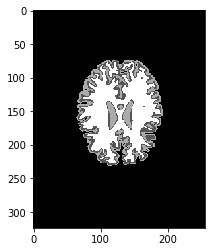

Loop stopped
********************************************************************
Step 0
Distribution change 0.014119
0.3258596270909987 0.3505693540462939 0.3235710188627074


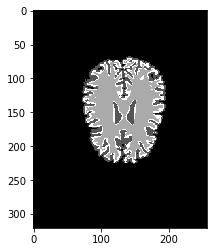

********************************************************************
Step 1
Distribution change 0.006485
0.32951185410184264 0.35206382097997857 0.31842432491817874


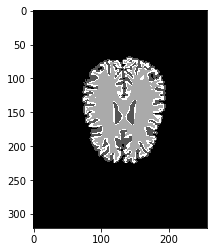

Loop stopped
********************************************************************
Step 0
Distribution change 0.009118
0.33270047622426224 0.32671326614961016 0.3405862576261276


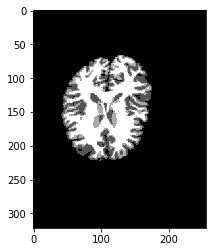

Loop stopped
********************************************************************
Step 0
Distribution change 0.034302
0.4584558414519795 0.3593207066292364 0.18222345191878417


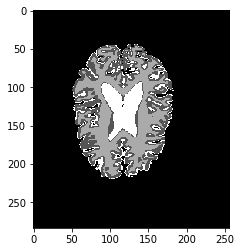

********************************************************************
Step 1
Distribution change 0.105714
0.5281240112059711 0.36861735711881133 0.10325863167521755


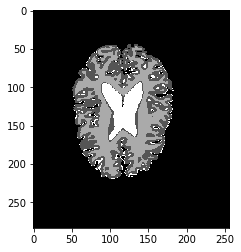

********************************************************************
Step 2
Distribution change 0.094431
0.5783637779553292 0.39414865105016245 0.027487570994508267


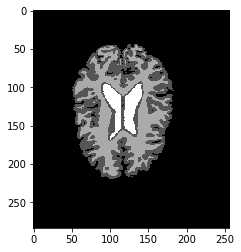

********************************************************************
Step 3
Distribution change 0.055454
0.556334711203515 0.4394211500424053 0.004244138754079791


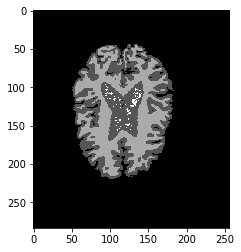

********************************************************************
Step 4
Distribution change 0.028085
0.5779729559866557 0.4220270440133443 7.224065964391134e-07


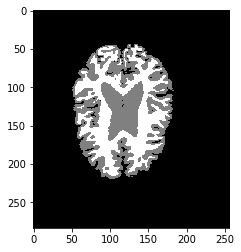

********************************************************************
Step 5
Distribution change 0.030866
0.5997983040782742 0.4002016959217258 7.224065964391134e-07


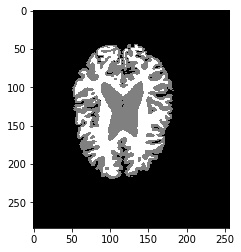

********************************************************************
Step 6
Distribution change 0.025024
0.6174929312514539 0.3825070687485462 7.224065964391134e-07


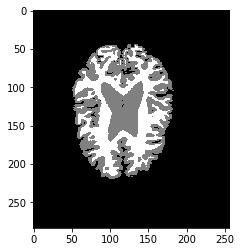

/home/okozyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars
/home/okozyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide


********************************************************************
Step 7
Distribution change 0.540946
1.0 7.224065964391134e-07 7.224065964391134e-07


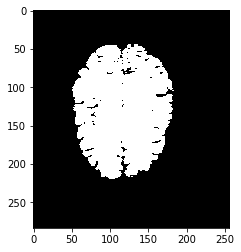

********************************************************************
Step 8
Distribution change 0.000000
1.0 7.224065964391134e-07 7.224065964391134e-07


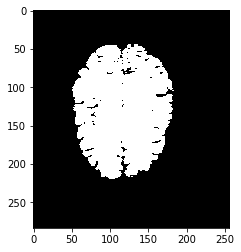

Loop stopped


/home/okozyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in greater
/home/okozyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in greater
/home/okozyn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in greater


********************************************************************
Step 0
Distribution change 0.029382
0.3536347302893131 0.4564327636187135 0.18993250609197343


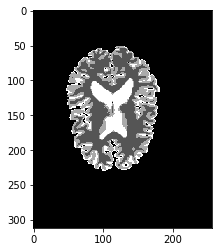

********************************************************************
Step 1
Distribution change 0.080649
0.36141705413431097 0.5091695769425606 0.12941336892312844


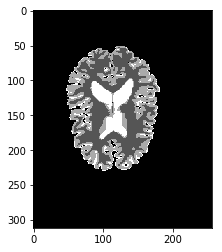

********************************************************************
Step 2
Distribution change 0.128342
0.3797660993071153 0.5893448222994842 0.03088907839340053


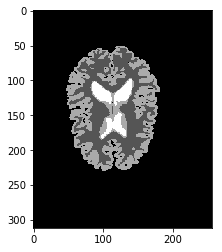

********************************************************************
Step 3
Distribution change 0.109338
0.46774839672824464 0.5322494837101089 2.1195616463907045e-06


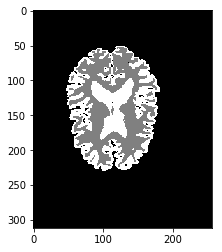

********************************************************************
Step 4
Distribution change 0.036080
0.44223735275228615 0.5577626472477138 7.065205487969014e-07


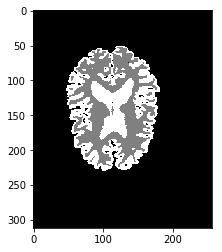

********************************************************************
Step 5
Distribution change 0.035178
0.4173628837907936 0.5826371162092064 7.065205487969014e-07


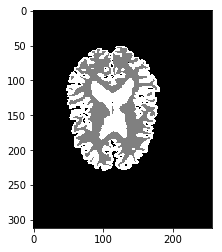

********************************************************************
Step 6
Distribution change 0.029474
0.3965219406423826 0.6034780593576173 7.065205487969014e-07


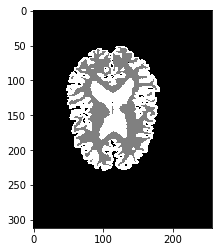

********************************************************************
Step 7
Distribution change 0.853446
1.0 7.065205487969014e-07 7.065205487969014e-07


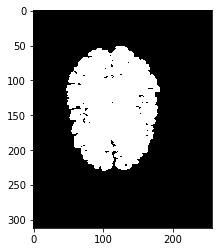

********************************************************************
Step 8
Distribution change 0.000000
1.0 7.065205487969014e-07 7.065205487969014e-07


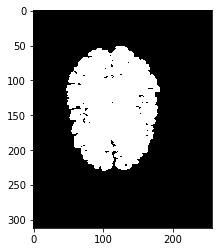

Loop stopped
********************************************************************
Step 0
Distribution change 0.005549
0.2323859846453655 0.3886032289948114 0.3790107863598231


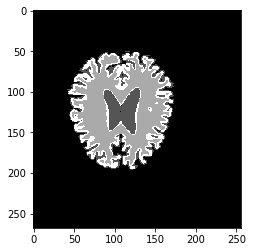

Loop stopped
********************************************************************
Step 0
Distribution change 0.001896
0.38884466482151964 0.3480972966645205 0.26305803851395987


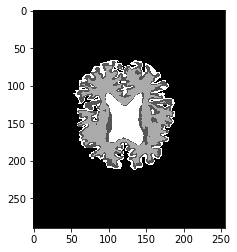

Loop stopped
********************************************************************
Step 0
Distribution change 0.003571
0.34008833724813464 0.22108475402194236 0.438826908729923


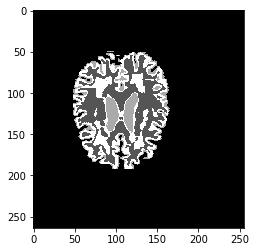

Loop stopped
********************************************************************
Step 0
Distribution change 0.008058
0.3684525940446658 0.31472100831589356 0.31682639763944065


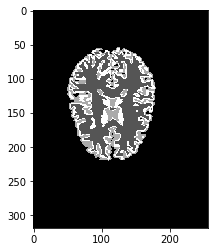

Loop stopped
********************************************************************
Step 0
Distribution change 0.012105
0.3570835224567308 0.3432877820853309 0.2996286954579383


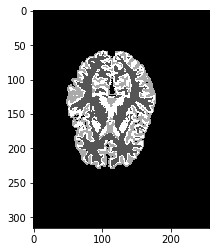

********************************************************************
Step 1
Distribution change 0.009852
0.3536280293196248 0.35130608419574927 0.29506588648462595


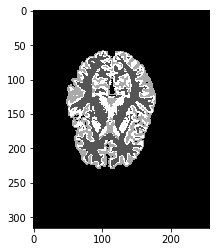

Loop stopped
********************************************************************
Step 0
Distribution change 0.002016
0.3541326424741876 0.3521858094902593 0.29368154803555313


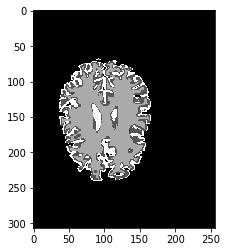

Loop stopped
********************************************************************
Step 0
Distribution change 0.016933
0.35278103239444325 0.3511155184884571 0.2961034491170996


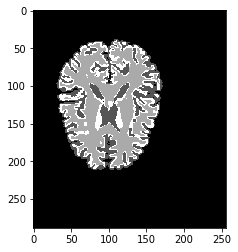

********************************************************************
Step 1
Distribution change 0.015300
0.3650495269505337 0.34702030595081657 0.2879301670986497


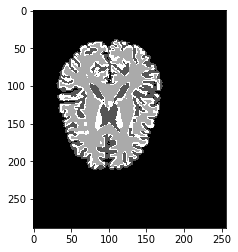

********************************************************************
Step 2
Distribution change 0.019887
0.38122729781248 0.3401353905880662 0.2786373115994538


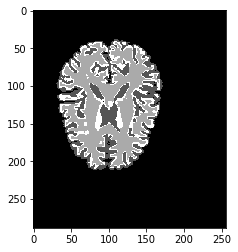

********************************************************************
Step 3
Distribution change 0.030445
0.4058130787017959 0.3310212184889187 0.2631657028092855


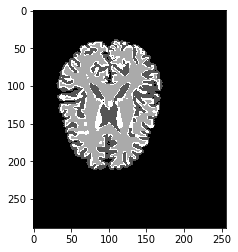

********************************************************************
Step 4
Distribution change 0.052919
0.44173767298827876 0.33384982286606857 0.2244125041456527


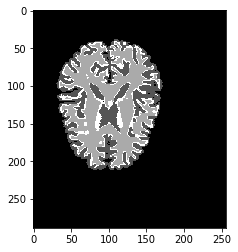

********************************************************************
Step 5
Distribution change 0.244949
0.4716443949786668 0.4901542809179975 0.03820132410333571


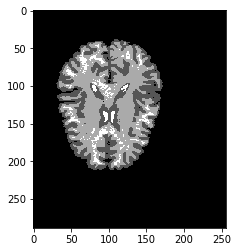

********************************************************************
Step 6
Distribution change 0.220990
0.3380234978561289 0.6619765021438712 6.593483396619785e-07


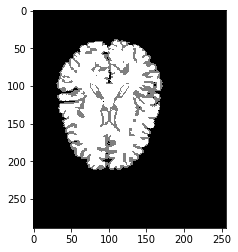

********************************************************************
Step 7
Distribution change 0.006970
0.33309486901715557 0.6669051309828444 6.593483396619785e-07


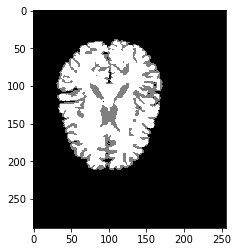

Loop stopped
********************************************************************
Step 0
Distribution change 0.008208
0.33971158044095173 0.32902375300152803 0.3312646665575202


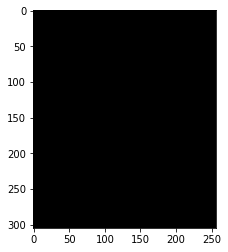

Loop stopped
********************************************************************
Step 0
Distribution change 0.015186
0.3647587625006732 0.3371012299594134 0.29814000753991343


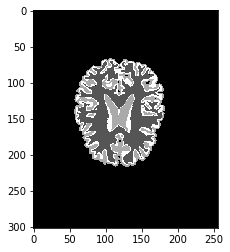

********************************************************************
Step 1
Distribution change 0.010686
0.3625718344503412 0.3455099109248401 0.2919182546248187


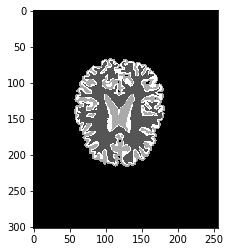

********************************************************************
Step 2
Distribution change 0.014259
0.35962385190691826 0.35673767193253986 0.2836384761605419


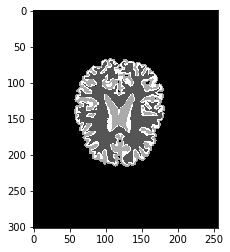

********************************************************************
Step 3
Distribution change 0.023964
0.35445892292248454 0.375664267255498 0.26987680982201745


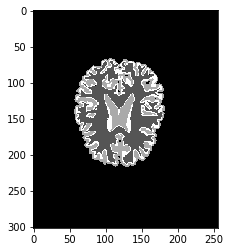

********************************************************************
Step 4
Distribution change 0.037671
0.34938493200393067 0.40447397626251613 0.24614109173355322


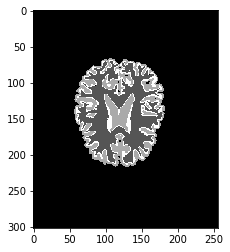

********************************************************************
Step 5
Distribution change 0.106659
0.38583961880175416 0.45473977145409966 0.15942060974414618


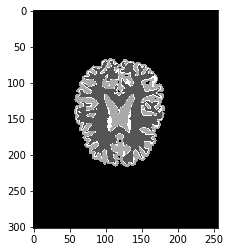

********************************************************************
Step 6
Distribution change 0.268120
0.5967179304261994 0.40021136478613223 0.0030707047876684453


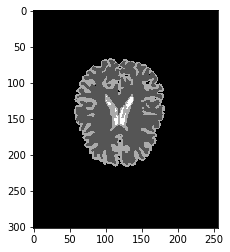

********************************************************************
Step 7
Distribution change 0.148123
0.7029583124013918 0.2970416875986082 8.8289384349294e-07


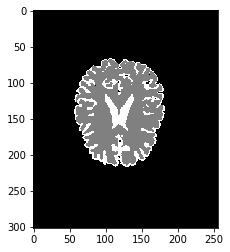

********************************************************************
Step 8
Distribution change 0.048574
0.668611093207986 0.33138890679201405 8.8289384349294e-07


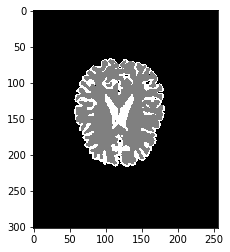

********************************************************************
Step 9
Distribution change 0.010095
0.6614728964833455 0.3385271035166545 8.8289384349294e-07


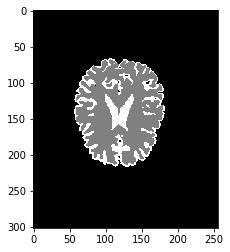

********************************************************************
Step 10
Distribution change 0.021709
0.6461220212265338 0.3538779787734662 8.8289384349294e-07


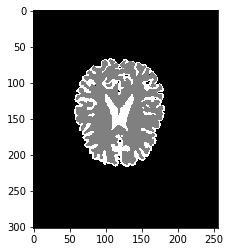

********************************************************************
Step 11
Distribution change 0.019366
0.6324283377139582 0.3675716622860417 8.8289384349294e-07


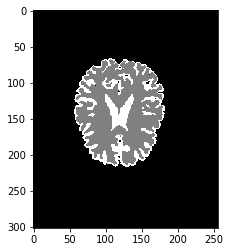

********************************************************************
Step 12
Distribution change 0.022745
0.6163455434608909 0.3836544565391091 8.8289384349294e-07


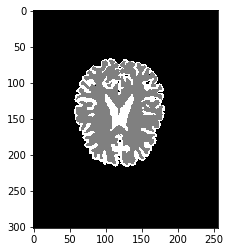

********************************************************************
Step 13
Distribution change 0.022290
0.6005841225668549 0.39941587743314505 8.8289384349294e-07


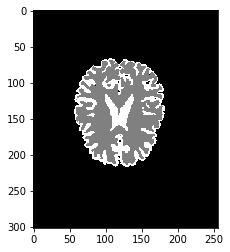

********************************************************************
Step 14
Distribution change 0.024556
0.5832202493468793 0.41677975065312073 8.8289384349294e-07


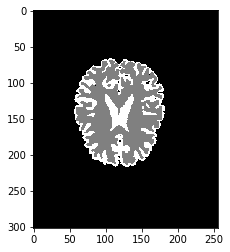

********************************************************************
Step 15
Distribution change 0.023572
0.566552096475576 0.4334479035244239 8.8289384349294e-07


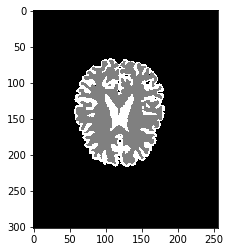

********************************************************************
Step 16
Distribution change 0.025431
0.5485693146713119 0.45143068532868813 8.8289384349294e-07


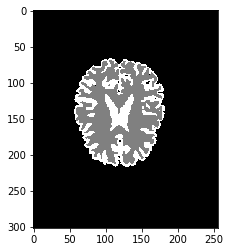

********************************************************************
Step 17
Distribution change 0.025932
0.530232492435807 0.469767507564193 8.8289384349294e-07


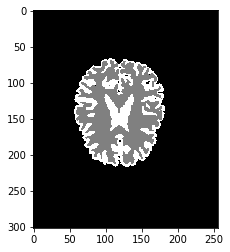

********************************************************************
Step 18
Distribution change 0.024295
0.5130531440291214 0.4869468559708786 8.8289384349294e-07


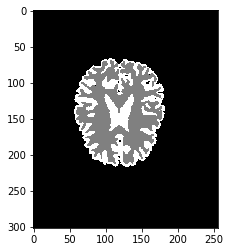

********************************************************************
Step 19
Distribution change 0.025338
0.49513657926311916 0.5048634207368808 8.8289384349294e-07


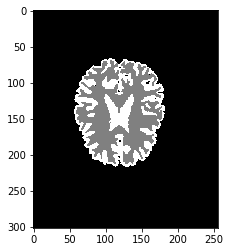

********************************************************************
Step 20
Distribution change 0.022636
0.47913059677443565 0.5208694032255644 8.8289384349294e-07


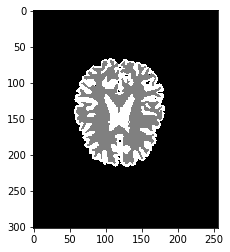

********************************************************************
Step 21
Distribution change 0.022447
0.4632579312561196 0.5367420687438804 8.8289384349294e-07


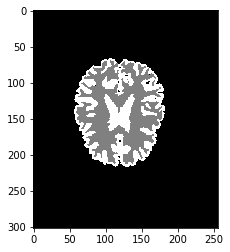

********************************************************************
Step 22
Distribution change 0.020361
0.4488605813502802 0.5511394186497198 8.8289384349294e-07


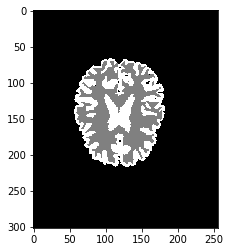

********************************************************************
Step 23
Distribution change 0.018291
0.4359270694369521 0.5640729305630479 8.8289384349294e-07


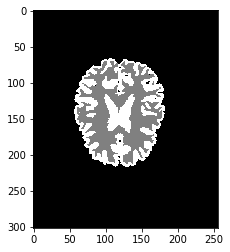

********************************************************************
Step 24
Distribution change 0.016344
0.4243699890256295 0.5756300109743705 8.8289384349294e-07


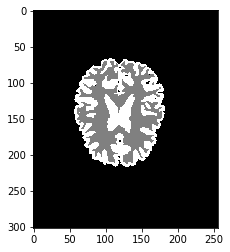

********************************************************************
Step 25
Distribution change 0.013599
0.4147543921761479 0.585245607823852 8.8289384349294e-07


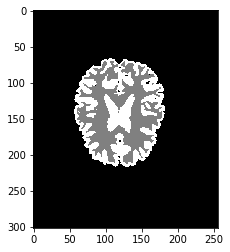

********************************************************************
Step 26
Distribution change 0.010137
0.4075861770608287 0.5924138229391712 8.8289384349294e-07


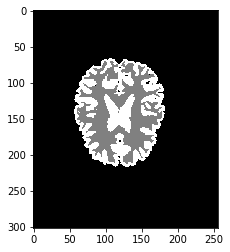

********************************************************************
Step 27
Distribution change 0.008276
0.40173435666615753 0.5982656433338425 8.8289384349294e-07


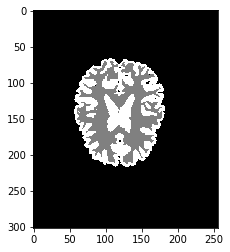

Loop stopped
********************************************************************
Step 0
Distribution change 0.012573
0.3349291564473784 0.3597145841131403 0.3053562594394813


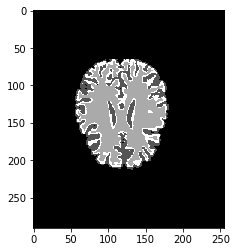

********************************************************************
Step 1
Distribution change 0.009180
0.3417382344036429 0.35902442769804477 0.2992373378983123


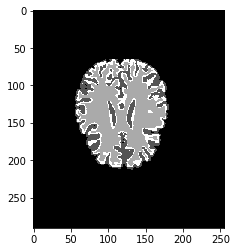

Loop stopped
********************************************************************
Step 0
Distribution change 0.017552
0.3541042982081839 0.29669409695431165 0.34920160483750445


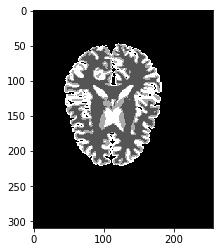

********************************************************************
Step 1
Distribution change 0.014994
0.350499973288774 0.28836357562556675 0.36113645108565917


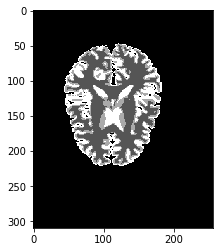

********************************************************************
Step 2
Distribution change 0.021485
0.34317298257548967 0.2782234532678649 0.3786035641566454


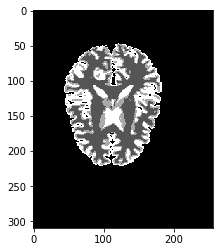

********************************************************************
Step 3
Distribution change 0.030816
0.33367392964060216 0.2627951844055129 0.4035308859538849


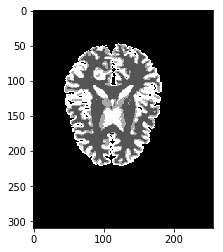

********************************************************************
Step 4
Distribution change 0.058581
0.3387943702202966 0.21904963486768475 0.4421559949120186


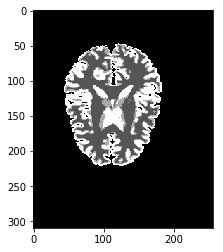

********************************************************************
Step 5
Distribution change 0.251898
0.5075159979956437 0.03282640610936455 0.4596575958949917


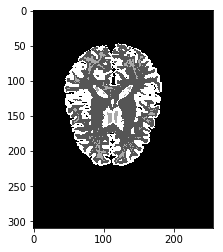

********************************************************************
Step 6
Distribution change 0.568678
0.6804796389453732 0.31952036105462683 6.762335683695806e-07


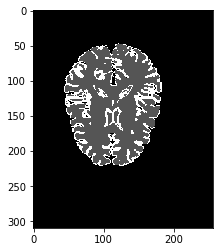

********************************************************************
Step 7
Distribution change 0.446605
0.9962773342061254 0.003722665793874541 6.762335683695806e-07


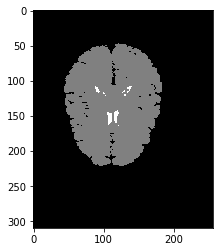

********************************************************************
Step 8
Distribution change 0.002362
0.9979476311199983 0.002052368880001677 6.762335683695806e-07


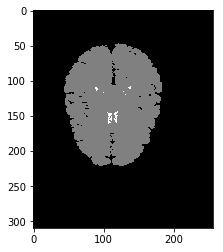

Loop stopped
********************************************************************
Step 0
Distribution change 0.010993
0.2318138384415182 0.3956356368707549 0.37255052468772687


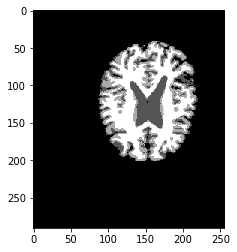

********************************************************************
Step 1
Distribution change 0.027683
0.21015988843391403 0.4120757088377672 0.3777644027283188


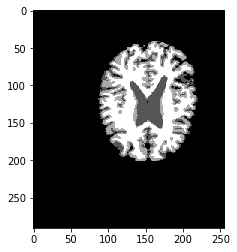

********************************************************************
Step 2
Distribution change 0.084994
0.14528914497565232 0.4658615811508409 0.38884927387350676


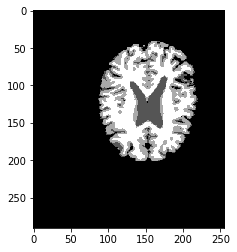

********************************************************************
Step 3
Distribution change 0.164822
0.016922147647155036 0.5650386090968829 0.4180392432559621


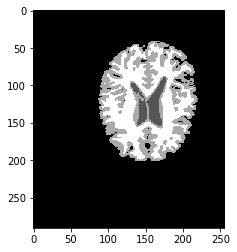

********************************************************************
Step 4
Distribution change 0.612390
0.4635200707044331 0.5364799292955669 7.173745240220033e-07


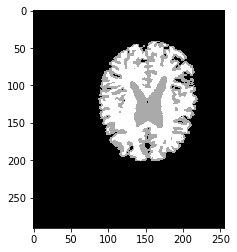

********************************************************************
Step 5
Distribution change 0.655508
5.738996192176026e-06 0.9999942610038078 7.173745240220033e-07


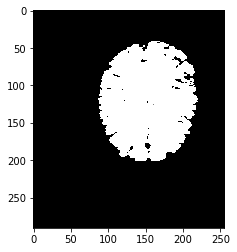

********************************************************************
Step 6
Distribution change 1.414205
1.0 7.173745240220033e-07 7.173745240220033e-07


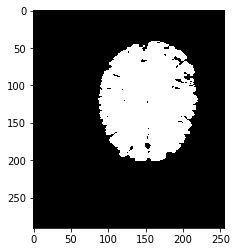

********************************************************************
Step 7
Distribution change 0.000000
1.0 7.173745240220033e-07 7.173745240220033e-07


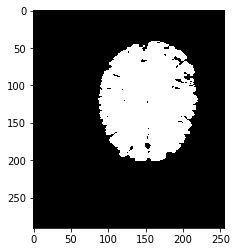

Loop stopped
********************************************************************
Step 0
Distribution change 0.014630
0.35459859813794165 0.3304795375461553 0.314921864315903


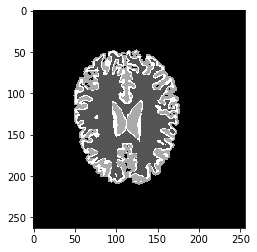

********************************************************************
Step 1
Distribution change 0.007746
0.35378963675607933 0.3363159261920422 0.30989443705187847


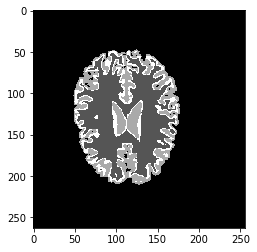

Loop stopped
********************************************************************
Step 0
Distribution change 0.013374
0.3888438511248275 0.4241969600630014 0.1869591888121711


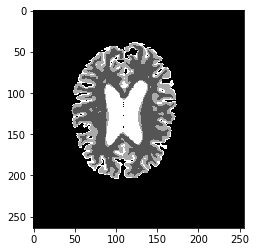

********************************************************************
Step 1
Distribution change 0.028119
0.39284718948163566 0.44177414088493355 0.16537866963343079


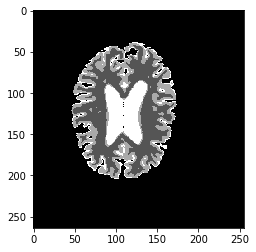

********************************************************************
Step 2
Distribution change 0.068084
0.40371478119491955 0.48355440856615783 0.11273081023892265


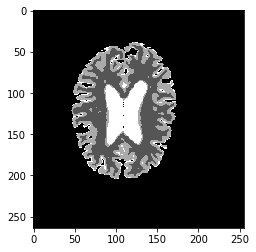

********************************************************************
Step 3
Distribution change 0.092475
0.4335537734714204 0.5287021726964554 0.037744053832124286


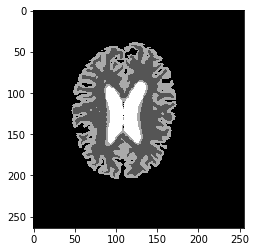

********************************************************************
Step 4
Distribution change 0.096512
0.5123324190459682 0.4876630979323557 4.483021676156974e-06


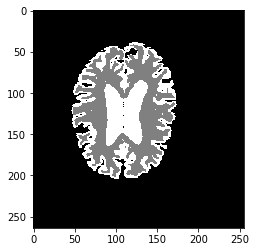

********************************************************************
Step 5
Distribution change 0.007201
0.5072426951029713 0.49275730489702874 7.471702793594957e-07


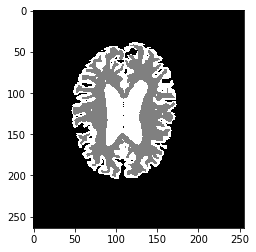

Loop stopped
********************************************************************
Step 0
Distribution change 0.003105
0.3464629084652293 0.3439456386117184 0.3095914529230523


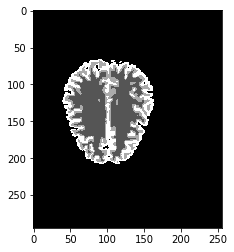

Loop stopped


In [5]:
if use_atlas == 'our':
    # Path to test image
    test_img_path = "./test-set/testing-images/"
    atlas_path = "./test-set/registration-results/our_atlases/"
    result_path = "./test-set/segmentation-results/our-EM-atlas-segmentation/"
    gt_path = "./test-set/testing-labels/"
    mask_path = "./test-set/testing-mask/"
    
    out_dice_path = 'our_EM_atlas_dice.csv'
    
elif use_atlas == 'mni':
    # Path to test image
    test_img_path = "./test-set/testing-images/"
    atlas_path = "./test-set/registration-results/mni_atlases/"
    result_path = "./test-set/segmentation-results/mni-EM-atlas-segmentation/"
    gt_path = "./test-set/testing-labels/"
    mask_path = "./test-set/testing-mask/"
    
    out_dice_path = 'mni_EM_atlas_dice.csv'
else:
    raise ValueError("our_atlas values should be either mni' or 'our'")

onlydirs = [f[:-7] for f in listdir(test_img_path)]

all_dice = np.zeros((len(onlydirs),3))

# Key the labels already in the files
CSF_label = 1
GM_label = 3
WM_label = 2

for i, f in enumerate(onlydirs):
    # Load all data for EM algorithm
    test_data, test_img = read_im(join(test_img_path,f+'.nii.gz'))
    GM_atlas, _ = read_im(join(atlas_path, f,'gm','result.nii.gz'))
    WM_atlas, _ = read_im(join(atlas_path, f,'wm','result.nii.gz'))
    CSF_atlas, _ = read_im(join(atlas_path, f,'csf','result.nii.gz'))
    _, groundtruth_img = read_im(join(gt_path,f+"_3C.nii.gz"))
    mask_data, _ = read_im(join(mask_path,f+"_1C.nii.gz"))

    #show_slice_data(test_data, np.s_[:, :, 150])
    # Apply mask from GT image
    test_masked = apply_mask(test_data, mask_data)
    #show_slice_data(test_masked, np.s_[:, :, 150])

    # Pre-process feature vector to remove background points from algorithm
    # and save those indicies to add back
    features = test_masked.copy().flatten()
    features = np.transpose(features)   
    features_nonzero_row_indicies = np.nonzero(features)
    features_nonzero = features[features_nonzero_row_indicies]

    if class_init == 'kmeans':
        features_nonzero_reshaped = features_nonzero.reshape(-1, 1)
        kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++')\
        .fit(features_nonzero_reshaped)
        y_pred = kmeans.predict(features_nonzero_reshaped)
        centroids = kmeans.cluster_centers_

        class0 = features_nonzero_reshaped[np.argwhere(y_pred == 0)[:,0],:]
        class1 = features_nonzero_reshaped[np.argwhere(y_pred == 1)[:,0],:]
        class2 = features_nonzero_reshaped[np.argwhere(y_pred == 2)[:,0],:]

        # Compute mean and variance of each class
        mean0 = np.mean(class0, axis = 0)
        mean1 = np.mean(class1, axis = 0)
        mean2 = np.mean(class2, axis = 0)
        cov0 = np.cov(class0, rowvar = False)
        cov1 = np.cov(class1, rowvar = False)
        cov2 = np.cov(class2, rowvar = False)

        # Class distribution
        a0 = class0.shape[0] / features_nonzero_reshaped.shape[0]
        a1 = class1.shape[0] / features_nonzero_reshaped.shape[0]
        a2 = class2.shape[0] / features_nonzero_reshaped.shape[0]

    else:
        raise ValueError("Incorrect class_init value, shoulb be one from ('kmeans', 'random')")

    cls_dist = np.array((a0, a1, a2))
    n_steps = 0

    while True:
        # Expectation step: Recompute labels for all the dataset given the current cluster parameters.
        # Compute Gaussian mixture model for each point
        p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
        p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
        p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)


        # # Compute membership weight for each point
        weights = membership_weight(p0, p1, p2, a0, a1, a2)


        #################################### 

        # Maximization step: Use that classification to reestimate the parameters
        y_pred = np.argmax(weights, axis=1)

        # Class distribution
        _, counts = np.unique(y_pred, return_counts=True)

        if len(counts) == 2:
            counts = [counts[0], counts[1], 1]
        elif len(counts) == 1:
            counts = [counts[0], 1, 1]

        a0 = counts[0] / len(features_nonzero)
        a1 = counts[1] / len(features_nonzero)
        a2 = counts[2] / len(features_nonzero)

        cls_dist_new = np.array((a0, a1, a2))

        #print(cls_dist_new)

        # Calculate mean and covariance for new classes
        mean0 = (1/counts[0]) * (weights[:, 0] @ features_nonzero)
        mean1 = (1/counts[1]) * (weights[:, 1] @ features_nonzero)
        mean2 = (1/counts[2]) * (weights[:, 2] @ features_nonzero)
        cov0 = (1/counts[0]) * ((weights[:, 0] * (features_nonzero - mean0)) @ (features_nonzero - mean0))
        cov1 = (1/counts[1]) * ((weights[:, 1] * (features_nonzero - mean1)) @ (features_nonzero - mean1))
        cov2 = (1/counts[2]) * ((weights[:, 2] * (features_nonzero - mean2)) @ (features_nonzero - mean2))

        segment_img = seg_data_to_nii(test_img, y_pred, features_nonzero_row_indicies)
        dist_change = norm(cls_dist_new - cls_dist)
        print("********************************************************************")
        print("Step %d" % n_steps)
        print("Distribution change %f" % dist_change)
        print(a0, a1, a2)
        show_slice(segment_img, np.s_[:, :, 150])

        n_steps += 1

        # check whether we reached desired precision or max number of steps
        if (n_steps >= MAX_STEPS) or (dist_change <= min_change):
            print("Loop stopped")
            break
        else:
            cls_dist = cls_dist_new

    segment_nii_atlas = integrate_atlas_nii(test_img, y_pred, features_nonzero, 
                               features_nonzero_row_indicies, weights, CSF_atlas, 
                               GM_atlas, WM_atlas)

    # Calculate DICE
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segment_nii_atlas, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    os.mkdir(new_dir)
    nib.save(segment_nii_atlas, join(new_dir,'atlas_EM_seg.nii.gz'))

        
# Save DICE values
with open(out_dice_path, 'w+') as out_f:
    out_f.write('img,csf,gm,wm,\n')
    for index, row in enumerate(all_dice): 
        out_f.write(onlydirs[index] + ',' + ','.join(str(j) for j in row) + ',\n')

In [6]:
print(all_dice)

[[0.16428383 0.35426144 0.09231055]
 [0.15322382 0.66355013 0.15077167]
 [0.00293665 0.7618702  0.73993402]
 [0.00674108 0.08246722 0.04950327]
 [0.00616321 0.07868094 0.04474524]
 [0.14728193 0.41314186 0.10954492]
 [0.03067181 0.66126175 0.70130601]
 [0.01038322 0.58735692 0.63632769]
 [0.00208285 0.73903615 0.73119596]
 [0.00295207 0.78239834 0.75695271]
 [0.00376128 0.73625743 0.71884968]
 [0.00937478 0.82888169 0.71835946]
 [0.0285005  0.27239547 0.13773153]
 [0.11578839 0.81660134 0.66439433]
 [0.06531288 0.32656605 0.09723574]
 [0.28314754 0.07973718 0.05425761]
 [0.00451999 0.08072924 0.05107899]
 [0.05812242 0.27232412 0.15314427]
 [0.65128788 0.81656525 0.65928434]
 [0.1469271  0.4217715  0.11454173]]
